# Single Cell apoptosis

#### As decribed in Monier et al. 2015

In [4]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config
#from tyssue.config.json_parser import load_default

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel

from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

#from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.io.hdf5 import load_datasets

### Loading the datasets and specifications

Here it is a cylindrical hexagonal mesh.

In [5]:
ls

Apoptosis.ipynb            Cell Division.ipynb        Type 1 transition.ipynb
Boundary conditions.ipynb  Energy minimization.ipynb


In [6]:
# h5store = 'before_apoptosis.hf5'
h5store = '../data/hf5/small_hexagonal.hf5'

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs)


live_edges = sheet.upcast_face(sheet.face_df.is_alive)
dead_src = set(sheet.edge_df[live_edges==0].srce)

### Boundary conditions
sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

In [7]:
sheet.vert_df.groupby('is_active').mean()

,y,z,x,rho,old_idx,basal_shift,height,radial_tension
is_active,,,,,,,,
0,6.661338e-16,4.969103e-10,-1.276756e-15,5.987904,103.5,-2.878023,8.865927,0.0
1,8.604228e-16,-2.220446e-16,-1.915135e-15,5.987904,103.5,-2.878023,8.865927,0.0


In [8]:
min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


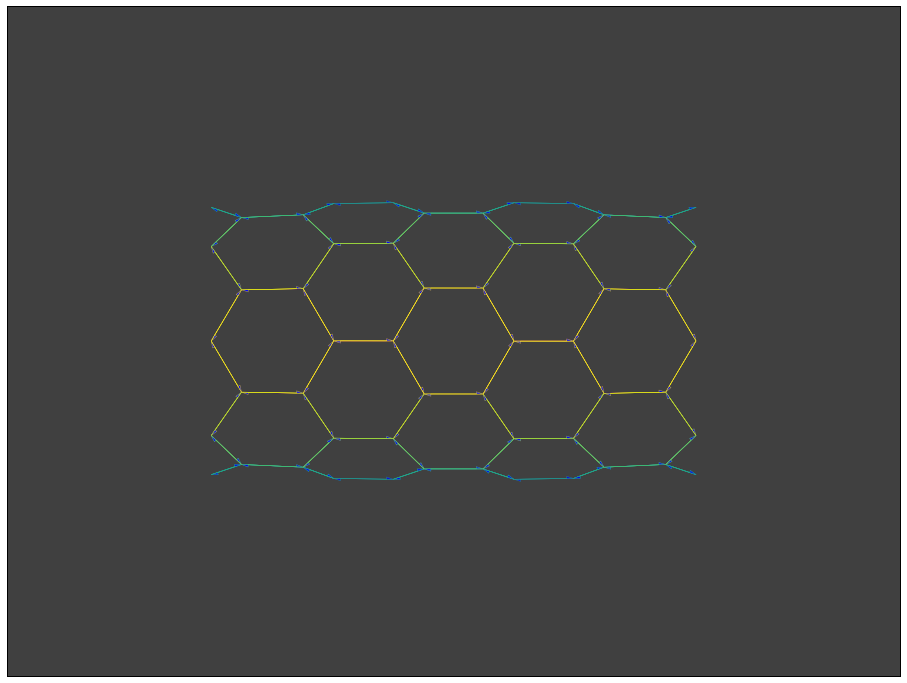

In [9]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-15, 15)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches((16, 19))
    return fig, ax

fig, ax = leg_joint_view(sheet)


In [10]:
apoptotic_cell = 16
print('Apoptotic cell position:\n{}'.format(sheet.face_df.loc[apoptotic_cell, sheet.coords]))
apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Apoptotic cell position:
x   -2.238969
y    5.413359
z   -4.033463
Name: 16, dtype: float64
Indices of the apoptotic vertices: [28 39 29 38 40 41]


In [11]:
from tyssue.behaviors.sheet_events import SheetEvents
from tyssue.behaviors.behaviors import apoptosis_time_table
events = SheetEvents(sheet, model, geom).events

print('Defined events (single time step):')
print('\n'.join([k for k in events]))


Defined events (single time step):
type1_at_shorter
ab_pull
shrink
contract
type3
grow
divide


In [12]:
sheet.settings['apoptosis'] = {
    'shrink_steps': 20,
    'rad_tension': 1,
    'contractile_increase': 2,
    'contract_span': 2
    }

times, time_table = apoptosis_time_table(sheet,
                                         apoptotic_cell,
                                         events,
                                         start_t=0)

In [13]:
time_table.ab_pull.dropna()

t   face
0   16      0.05
1   16      0.05
2   16      0.05
3   16      0.05
4   16      0.05
5   16      0.05
6   16      0.05
7   16      0.05
8   16      0.05
9   16      0.05
10  16      0.05
11  16      0.05
12  16      0.05
13  16      0.05
14  16      0.05
15  16      0.05
16  16      0.05
17  16      0.05
18  16      0.05
19  16      0.05
Name: ab_pull, dtype: object

In [14]:
for t in times:
    face_events = time_table.loc[t]
    for face, evts in face_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            events[event_name](face, event_arg)

    res = solver.find_energy_min(sheet, geom, model, **min_settings)
    fig, ax = leg_joint_view(sheet)
    plt.savefig('../data/png/single_apopto_{:03d}.png'.format(t))
    plt.close(fig)

In [15]:
ls


Apoptosis.ipynb            Cell Division.ipynb        Type 1 transition.ipynb
Boundary conditions.ipynb  Energy minimization.ipynb


providing you have ImageMagick on your system:

In [17]:
%%bash
convert ../data/png/single_apopto_*.png ../data/gif/single_apopto.gif

Voilà!!

![The result of our simulation](../data/gif/single_apopto.gif)